Linear Regression

Read Data

In [33]:
import numpy as np
import pandas as pd
import math
import re

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


df_train = pd.read_csv('data/train.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
df_train_label = df_train[["Id", "SalePrice"]]
df_train = df_train.drop('SalePrice', axis=1)

df_train = df_train.set_index("Id")
df_train_label = df_train_label.set_index("Id")

df_test = pd.read_csv('data/test.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

test_null_columns=df_test.columns[df_test.isnull().any()] 
train_null_columns=df_train.columns[df_train.isnull().any()] 
test_null_only_ColIdx = test_null_columns.difference(train_null_columns)

test_null_only_RowIdx = [ df_test[df_test[idx].isnull()].index.tolist() for idx in test_null_only_ColIdx ]
test_null_only_RowIdx = list ( set(x for l in test_null_only_RowIdx for x in l) )

problematicTestSet = df_test.loc[ df_test.index.isin( test_null_only_RowIdx ) ]

fineTestSet = df_test.loc[ ~df_test.index.isin( test_null_only_RowIdx ) ]  #1447 records

problematicTestSet= problematicTestSet.set_index("Id")
fineTestSet = fineTestSet.set_index("Id")
df_test = df_test.set_index("Id")

df = pd.concat([df_train,df_test], axis=0, sort=True)

problematicTestSet.index

Int64Index([1556, 1916, 1946, 2121, 2152, 2189, 2217, 2251, 2474, 2490, 2577, 2905], dtype='int64', name='Id')

In [34]:
keep_cols = ['Neighborhood', 'YrSold', 'MoSold', 'OverallQual']
df = df[keep_cols]
df.YrSold = df.YrSold.astype('object')
df.MoSold = df.MoSold.astype('object')

df = pd.get_dummies(df[keep_cols], drop_first=True, dummy_na=True)

df_test = df[df.index >= min( df_test.index ) ]
df_train = df[df.index < min( df_test.index ) ]


df_train_label = df_train_label.astype(int)
df_train_label_log = np.log( df_train_label )


### GridSearchCV looking for best regulaization factor for different regression models.
- Lasso
- Ridge
- ElasticNet

Lasso

In [35]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train_label_log, test_size=0.2, random_state=0)


In [36]:
def evaluate(model, test_features, test_labels): 
    
    predictions = model.predict(test_features).ravel() 
    residuals = test_labels - predictions
    rmse = np.sqrt(((test_labels - predictions) ** 2).mean())
    rmsle = np.sqrt(np.mean((np.log1p(predictions) - np.log1p(test_labels))**2))    
    pred = pd.DataFrame( {'residuals': residuals.values, 'predictions': predictions} )
    pred.set_index(residuals.index)
    
    return [rmse, rmsle, pred]

{'alpha': 5.590810182512223e-05} 0.04063631636663398


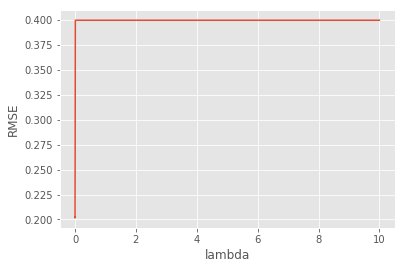

In [37]:
alphas = np.logspace(-7, 1, 100)

grid = GridSearchCV(estimator=Lasso(normalize=True),
    param_grid=dict(alpha=alphas), cv=5, scoring='neg_mean_squared_error' ) # scoring='r2'

grid.fit(df_train, df_train_label_log) # entire datasets were fed here

print (grid.best_params_, -grid.best_score_)

#means = grid.cv_results_['mean_test_score']
#stds = grid.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
scores = [np.sqrt(-x) for x in grid.cv_results_['mean_test_score'] ]
plt.plot(alphas, scores)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.show()

# the lambda is very small. Therefore, there is almost no regulization going on.


In [38]:
model_lasso = Lasso(alpha= grid.best_params_['alpha'], normalize=True)
model_lasso.fit(df_train, df_train_label_log)

Lasso(alpha=5.590810182512223e-05, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

RMSE = 0.1966
RMSLE = 0.0152


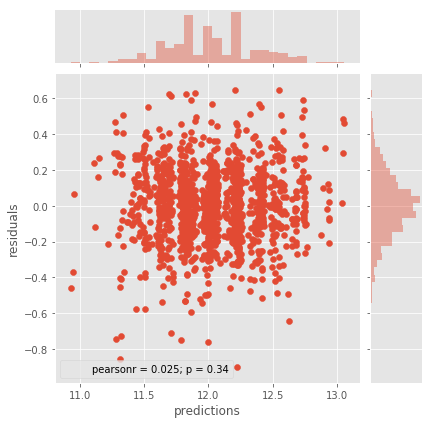

In [39]:
rmse, rmsle, pred = evaluate(model_lasso, df_train, df_train_label_log['SalePrice'] )
print('RMSE = {:0.4f}'.format(rmse))
print('RMSLE = {:0.4f}'.format(rmsle))
sns.jointplot(x = "predictions", y = "residuals",  data=pred )

In [40]:
best_lasso_test_y = model_lasso.predict(df_test)
best_lasso_test_y = np.expm1(best_lasso_test_y)
sub = pd.DataFrame()
sub['SalePrice'] = best_lasso_test_y
sub = sub.set_index(np.arange(1461, 2920))
sub.to_csv('3featureOnlyLasso.csv')

